# check the data

In [9]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = '/kaggle/input/cleaned-dataset/cleaned_dataset.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first few lines of the DataFrame
print(df.head())

                                       cleaned_tweet  label
0                  ልዩ የተፈጥሮ ገፅታ የምስራቅ አፍሪካ የውሀ ማማ ጮቄ      1
1                  ኢትዮጵያዊነቴ ተምታተውብኝ አያውቁም የሚል ይታከልበት      1
2  ሀሴትን ከበጎነት የሰው ልጅ በምድር ሲመላለስ ታላቅ የመንፈስ እርካታን ከ...      2
3  ለቅዳሚታችሁ በምትሰሩት ማንኛውም ነገር ምሉእነትና እርካታ ይሰማችሁ የአሁ...      1
4                ኮንዶሚኒየም ከሆነ እመልሳለሁ ካልሆነ መልሴን አላባክንም      1


In [10]:
df.shape

(16717, 2)

## prepare dataset

In [11]:
text = df['cleaned_tweet'].astype(str)
labels = df['label']

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

## Tokenize the text

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [18]:
#find the maximum number of words in a tweet to do some padding
tweet_lengths = text.apply(lambda x: len(x.split()))  # Split by spaces to count words
print(tweet_lengths.describe())

count    16717.000000
mean        12.379614
std          6.749070
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         34.000000
Name: cleaned_tweet, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


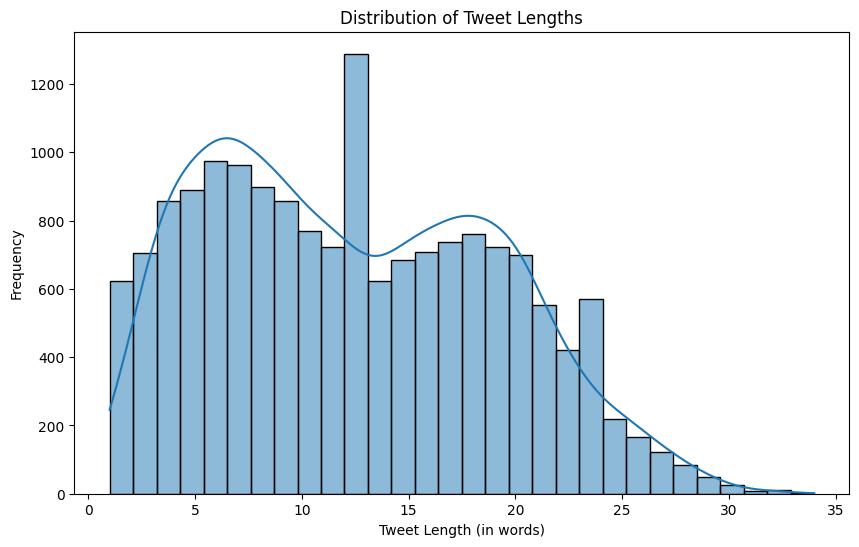

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length (in words)")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Calculate the 95th percentile of tweet lengths
max_length = int(tweet_lengths.quantile(0.95))
print(f"Recommended max_length: {max_length}")

Recommended max_length: 24


## Apply Padding

In [22]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

##  Build the LSTM Model

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Define the model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 200  # Dimension of word embeddings
lstm_units = 64  # Number of LSTM units
optimizer = Adam(learning_rate=0.001)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(lstm_units, return_sequences=False),
    Dropout(0.8),  # Dropout for regularization
    Dense(64, activation='relu'),  # Fully connected layer
    Dense(3, activation='softmax')  # Output layer (3 classes: 0, 1, 2)
])

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Start training

In [69]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_padded, y_test)
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4508 - loss: 1.0692 - val_accuracy: 0.4865 - val_loss: 1.0111
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6762 - loss: 0.7951 - val_accuracy: 0.6956 - val_loss: 0.8182
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9261 - loss: 0.2673 - val_accuracy: 0.7605 - val_loss: 0.6954
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9631 - loss: 0.1454 - val_accuracy: 0.7946 - val_loss: 0.7576
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9740 - loss: 0.0826 - val_accuracy: 0.7961 - val_loss: 0.8626
Epoch 6/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9788 - loss: 0.0675 - val_accuracy: 0.7996 - val_loss: 1.0997
Epoch 7/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9790 - loss: 0.0573 - val_accuracy: 0.7904 - val_loss: 1.2383
Epoch 8/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9806 - loss: 0.0548 - val_accuracy: 0

## Evaluate the Model

In [70]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7918 - loss: 1.6308
Test Loss: 1.6081606149673462
Test Accuracy: 0.7984449863433838


## Test inference

In [71]:
# Example: Predict sentiment for a new tweet
new_tweet = ["አሪፍ ፊልም ነው።"]  # Replace with your tweet
new_tweet_sequence = tokenizer.texts_to_sequences(new_tweet)
new_tweet_padded = pad_sequences(new_tweet_sequence, maxlen=max_length, padding='post', truncating='post')

# Predict sentiment
prediction = model.predict(new_tweet_padded)
predicted_class = prediction.argmax(axis=-1)[0]

# Map predicted class to sentiment label
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"Predicted Sentiment: {sentiment_map[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted Sentiment: Neutral


## Save the Model

In [72]:
# Save the model
model.save('/kaggle/working/lstm_sentiment_model.h5')

# Save the tokenizer
import pickle
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Visualize Training Performance

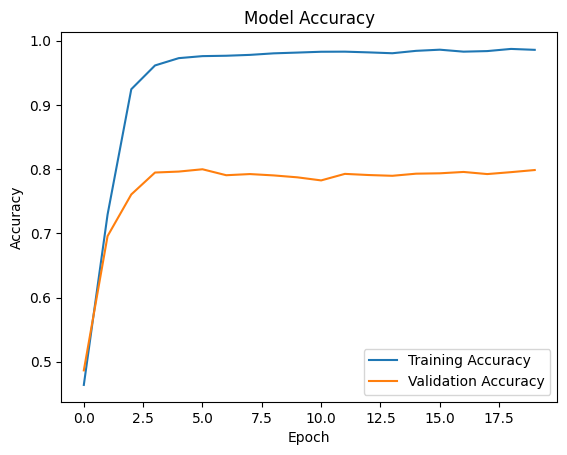

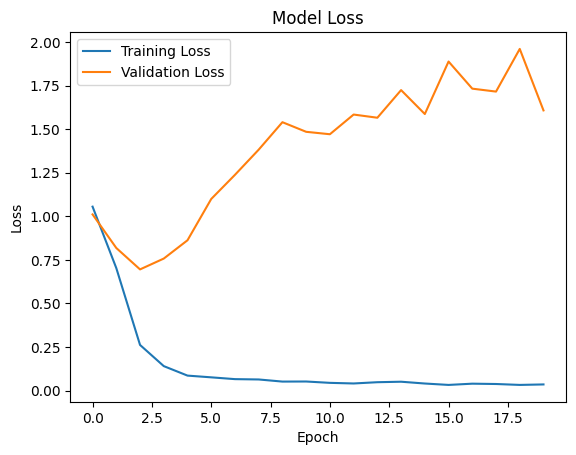

In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()